# Malaria challenge trial calibration

### A history matching approach to calibrating an empirical model of malaria infection and immunity
### For iter0 we will cut down parameter space by using the distribution of infection durations by age in the KND cohort in Navrongo, Ghana

# Import block

In [2]:
from IPython.extensions import autoreload
%load_ext autoreload
%autoreload 2
import os, glob, re, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from wand.image import Image as WImage
from IPython.display import IFrame, display

from pyDOE import lhs
from history_matching import HistoryMatching, HistoryMatchingCut, quick_read, Basis

sns.set(font_scale=2)
sns.set_style("white")

Looks like you don't have CUDA, that's okay, we'll try using CPU but it will be SLOW!
Looks like you don't have CUDA, that's okay, we'll try using CPU but it will be SLOW!


In [3]:
def fix_glob(pth):
    return re.sub('([\[\]])','[\\1]', pth)

# Configure parameters and data for history matching

In [5]:
ref_data_path = os.path.join('..','reference data','GhanaDurations.xlsx')
ref_df = pd.read_excel(ref_data_path)
print(ref_df)
age_bin = ['20.0-40.0']
cut_name = f'Duration for all ages'

# iteration = int(re.search(r'iter(\d+)', os.getcwd())) # Index of the current iteration
iteration = 0 
#list of exp_ids/folders that correspond to exp_ids from which our emulation will draw
exp_ids = ['a7c53091-8db8-e911-a2c1-c4346bcb1555'] # TODO: only uses first for now, should loop
basedir = 'C:\git\Malaria-Uganda-PRISM'
datafile = os.path.join(basedir, 'v0-challengeTrial','reference data', 'Ghana_Durations.xlsx')

   Age bin  Mean  CI_lower  CI_upper
0        0   155       128       183
1        1   256       254       259
2        3   257       254       259
3        5   319       318       320
4       10   176       156       196
5       20   129       124       134
6       40   126       113       139
7       60   131       114       148
8      200     0         0         0


In [4]:
# The implausibility threshold determines how willing we are to retain regions
# of parameter space that are inconsistent with the underlying data. A higher
# threshold is more risk averse in that potentially good regions are less likely
# to be rejected, however it will take more iterations/simulations to achieve results.
implausibility_threshold = 3
training_fraction = 0.75 # Fraction of simulations to use as training
discrepancy_std = 0.0 # Accounts for uncertainty w.r.t model structure
n_samples_to_generate_for_next_iter = 1000 # Number of simulations to conduct on this iteration

In [5]:
# Here we define the parameter names and ranges
params_file = os.path.join('..','Params.xlsx')
param_info = quick_read(params_file, 'Params').set_index('Name')
param_names = param_info.index.tolist()

params = param_info.index.values
n_params = param_info.shape[0] # We'll use this one place later
display(param_info)

Reading Params from ..\Params_1aed7489c975abea315d4649ccac49be.hd5


,Min,Max,MapTo
Name,,,
TM_Fixed_Scale_Factor,-1,1,TM_Fixed_Scale_Factor
PPP_Scale_Factor,0,2,PPP_Scale_Factor


## Read in Sim Results

In [6]:
all_samples = []
all_results = []
for exp_id in exp_ids:
    
    print('-'*80, '\nExperiment:', exp_id)
    sim_results_fn = os.path.join(exp_id, 'analyzer_results.csv')
    print(sim_results_fn)
    sr = pd.read_csv(sim_results_fn, skipinitialspace=True)
    sr['Sample_Id'] = sr['sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    sr.rename(columns = {'sim_id': 'Sim_Id','age_cat': 'AgeBin','value':'Result'}, inplace=True)
    all_results.append( sr )
    #read in tags making a samples.xlsx file 
    s = pd.read_excel(os.path.join(exp_id, 'Samples.xlsx'))
    # s.drop('Sim_Id', axis=1, inplace=True)
    s['Sample_Id'] = s['Sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    all_samples.append( s )

#.rename(columns={'level_1': 'Year', 0: 'Cases'}) \
all_results = pd.concat(all_results) \
    .set_index(['Sample_Id', 'Sim_Id', 'AgeBin']) \
    [['Result']] \
    .sort_index()

samples = pd.concat(all_samples).set_index('Sample_Id').sort_index() # Bad because sample will be repeated across exp_id!
                       
samples.to_csv('Samples.csv')
all_results.to_csv('Results_by_age.csv')
results = all_results['Result']

results = all_results[ 
        
        (all_results.index.get_level_values('AgeBin').isin(age_bin))
    ] \
    .groupby(['Sample_Id', 'Sim_Id']) \
    .mean()

    
results.rename(columns={'Result':'Sim_Result'}, inplace=True)

display(results.head())

-------------------------------------------------------------------------------- 
Experiment: a7c53091-8db8-e911-a2c1-c4346bcb1555
a7c53091-8db8-e911-a2c1-c4346bcb1555\analyzer_results.csv


,,Sim_Result
Sample_Id,Sim_Id,
a7c53091-8db8-e911-a2c1-c4346bcb1555.000000,8d172099-8db8-e911-a2c1-c4346bcb1555,58.301
a7c53091-8db8-e911-a2c1-c4346bcb1555.000001,8e172099-8db8-e911-a2c1-c4346bcb1555,130.571
a7c53091-8db8-e911-a2c1-c4346bcb1555.000002,8f172099-8db8-e911-a2c1-c4346bcb1555,124.617
a7c53091-8db8-e911-a2c1-c4346bcb1555.000003,90172099-8db8-e911-a2c1-c4346bcb1555,54.710
a7c53091-8db8-e911-a2c1-c4346bcb1555.000004,91172099-8db8-e911-a2c1-c4346bcb1555,127.355


In [7]:
desired_result_ref_age = ref_df.loc[ref_df['Age bin'] == int(age_bin[0][:2])]
desired_result = desired_result_ref_age['Mean']
desired_result_std = (desired_result_ref_age['CI_upper']-desired_result_ref_age['CI_lower'])/(2*1.96)

desired_result = desired_result.values[[0]].item()
desired_result_std = desired_result_std.values[[0]].item()

print('Before logit, desired result is %.3f [%.3f, %.3f]: ' % (desired_result, desired_result-2*desired_result_std, desired_result+2*desired_result_std))


Before logit, desired result is 129.000 [123.898, 134.102]: 


,Sample,TM_Fixed_Scale_Factor,PPP_Scale_Factor,Sim_Result
Sample_Id,,,,
a7c53091-8db8-e911-a2c1-c4346bcb1555.000000,0,-0.371131,0.016958,58.301
a7c53091-8db8-e911-a2c1-c4346bcb1555.000001,1,0.634217,0.864926,130.571
a7c53091-8db8-e911-a2c1-c4346bcb1555.000002,2,0.906412,1.448446,124.617
a7c53091-8db8-e911-a2c1-c4346bcb1555.000003,3,-0.557040,0.194109,54.710
a7c53091-8db8-e911-a2c1-c4346bcb1555.000004,4,0.211538,0.418283,127.355


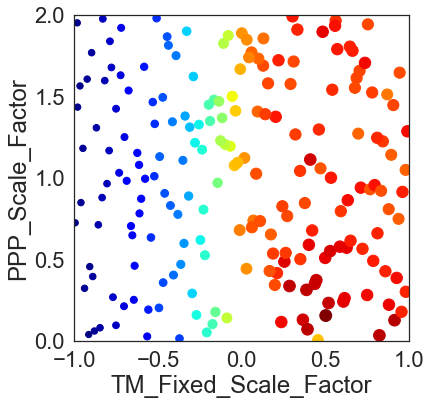

In [8]:
z = pd.merge(samples, results, on='Sample_Id') # Return to Sample_Id

display(z.head())

#sub in variables here, can be list of tuples
xyvars = [('TM_Fixed_Scale_Factor',	'PPP_Scale_Factor')]
for (xvar, yvar) in xyvars:
    fig = plt.figure(figsize=(6,6))
    plt.scatter(z[xvar], z[yvar], c=100*z['Sim_Result'], s=1*z['Sim_Result'], cmap='jet')
    plt.xlabel(xvar); plt.ylabel(yvar)
    plt.xlim([param_info.loc[xvar, 'Min'], param_info.loc[xvar, 'Max']])
    plt.ylim([param_info.loc[yvar, 'Min'], param_info.loc[yvar, 'Max']])
    # TODO: Show as surface and plot desired result as isocline
plt.show()

In [9]:
# Finally we get to do some History Matching!
# Begin by creating an instance of the HistoryMatching class
ext = 'svg' # Filetype for figures produced by history matching
hm = HistoryMatching(
    cut_name = cut_name,
    param_info = param_info,
    inputs = samples,
    results = results.squeeze(),
    desired_result = desired_result,
    desired_result_var = desired_result_std**2,
    iteration = iteration,
    implausibility_threshold = implausibility_threshold,
    discrepancy_var = discrepancy_std**2,
    training_fraction = training_fraction,
    fig_type = ext
)
hm.save() # Save to disk

Welcome to IDM History Matching!
Found 200 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 150 unique parameter configurations ( 150  simulations including replicates)
--> Testing  with 50  unique parameter configurations ( 50 simulations including replicates)


In [10]:
try:
    existing_basis = True
    need_basis = True
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json')) as data_file:
        config = json.load( data_file )
        basis_glm = Basis.deserialize(config['Basis'])
        fitted_values = pd.read_json(config['Fitted_Values'], orient='split').set_index(['Sample_Id', 'Sim_Id']).squeeze()
except:
    existing_basis = False
    
if existing_basis:
    print('Found existing GLM basis with the following terms:')
    display(basis_glm.model_terms)
    reply = input('Would you like to use this basis? [Y]/n: ')
    
    if reply.lower() != 'n':
        need_basis = False
    
if need_basis:
    basis_glm = Basis.polynomial_basis(params=param_names, intercept = True, first_order=True, second_order=True, third_order=False, param_info=param_info)

#     basis_glm.plot_regularize(samples, results, alpha = np.logspace(-5, -2, 15), scaleX=True)
#     alpha_glm = float(input('What would you like to use for the GLM regularization parameter, alpha_glm = '))
    alpha_glm = 1e-1
    
    fitted_values = basis_glm.regularize(samples, results, alpha = alpha_glm, scaleX=True)
    print('Regularization for GLM selected:\n', ' *','\n * '.join(basis_glm.get_terms()))
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json'), 'w') as fout:
        json.dump( {
            'Basis': basis_glm.serialize(),
            'Fitted_Values': fitted_values.reset_index().to_json(orient='split')
        }, fout, indent=4)

User selected alpha = 0.100000
Non-Zero: 2 of 6
Regularization for GLM selected:
  * Intercept
 * TM_Fixed_Scale_Factor


In [11]:
# Now fit the glm and plot

### GLM ###############################################################
print("="*80, "\nGeneralized Linear Modeling\n", "="*80)
#######################################################################
f = hm.glm(
    basis = basis_glm,
    family = 'Poisson',
    force_optimize_glm = True,
    glm_fit_maxiter = 100000,
    plot = True, #force_optimize_glm,
    plot_data = False
)

Generalized Linear Modeling
Plotting


In [12]:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [13]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "GLM Predicted vs Actual*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

..\iter0\Cuts\Duration for\GLM\GLM Predicted vs Actual.svg


In [16]:
basis_gpr = Basis.polynomial_basis(
    #params =  ['Scale_Factor_Age_a', 'Scale_Factor_Age_b'],
    params = param_info.index.values, #
    intercept = False, 
    first_order = True, 
    param_info=param_info)

In [17]:

### GPR ###############################################################
print("="*80, "\nGaussian Process Regression\n", "="*80)
#######################################################################
hm.gpr(
    basis = basis_gpr,
    force_optimize_gpr = True,

    sigma2_f_guess = 0.6,
    sigma2_f_bounds = (0.1, 1000),
    sigma2_n_guess =  2.0,
    sigma2_n_bounds = (0.01, 100),

    #lengthscale_guess = [0.09844299, 0.1256657, 0.0976875, 0.09889085, 0.1051974, 0.0950809, 0.10032171, 0.10599185, 0.10627393, 0.09950996, 0.09445544, 0.10285915, 0.10007409, 0.09847433, 0.08963389, 0.10205652, 0.09360044, 0.1024141, 0.09786228, 0.10247492, 0.09852253, 0.09632744, 0.09997534, 0.10767302, 0.10095249, 0.09941825, 0.10214923, 0.10221497, 0.09734157, 0.09093285, 0.10780673, 0.09881377, 0.10597152],
    lengthscale_guess = 0.25,
    lengthscale_bounds = (0.01, 100),

    optimize_sigma2_n = True,
    log_transform = False,

    verbose = True,
    optimizer_options = {
        'eps': 5e-3,
        'disp': True,
        'maxiter': 15000,
        'ftol': 2 * np.finfo(float).eps,
        'gtol': 2 * np.finfo(float).eps,
    },
    plot = True, #force_optimize_gpr,
    plot_data = False
)

Gaussian Process Regression
Autoinit GPU device name: GeForce GTX 965M
Backing up gpr model to ..\iter0\Cuts\Duration for\GPR\model_2019_08_06_14_53_17.json
Fitting the GPR

	LL: 209.03966278518536 
	Theta: [0.6  2.   0.25 0.25] 
	Deriv: [-12.14862135  32.79012821  53.94482754  -8.29281429]

	LL: 60.2739028211618 
	Theta: [1.27486213e+01 1.00000000e-02 1.00000000e-02 8.54281429e+00] 
	Deriv: [ 5.14483364e-01 -1.81112797e+04  1.11768560e+02 -1.29770973e+00]

	LL: 206.87232061333737 
	Theta: [0.69856816 1.98385408 0.24805275 0.31728396] 
	Deriv: [-9.7133241  33.58637752 51.9374015  -5.53032054]

	LL: 150.87639719952145 
	Theta: [1.2954728  1.0289186  0.01       0.58434731] 
	Deriv: [   1.46219387   68.3864679  -277.0202496    -2.81450249]

	LL: 47.003294572584565 
	Theta: [1.97614993 0.21819677 0.01       0.94094235] 
	Deriv: [   1.23185875  280.46493164 -463.52451941   -2.78689957]

	LL: 67.65549669461609 
	Theta: [2.15095068 0.01       0.01       1.03251746] 
	Deriv: [ 1.23211384e+00 -


	LL: -35.210366672341905 
	Theta: [1.39730877e+02 3.24653572e-02 3.30607749e-02 1.00000000e+02] 
	Deriv: [ 4.40603620e-03  6.62211052e+00  7.87911809e+00 -1.05292112e-02]

	LL: -35.21059543135496 
	Theta: [1.39730877e+02 3.24653572e-02 3.30607749e-02 1.00000000e+02] 
	Deriv: [ 4.05531786e-03  6.63586621e+00  7.40208978e+00 -1.05284818e-02]

	LL: -35.21059543135496 
	Theta: [1.39730877e+02 3.24653572e-02 3.30607749e-02 1.00000000e+02] 
	Deriv: [ 4.05531786e-03  6.63586621e+00  7.40208978e+00 -1.05284818e-02]

	LL: -35.21035450539321 
	Theta: [1.39730877e+02 3.24653572e-02 3.30607749e-02 1.00000000e+02] 
	Deriv: [ 4.24962782e-03  6.62117317e+00  7.33092592e+00 -1.05287793e-02]

	LL: -35.21059543135496 
	Theta: [1.39730877e+02 3.24653572e-02 3.30607749e-02 1.00000000e+02] 
	Deriv: [ 4.05531786e-03  6.63586621e+00  7.40208978e+00 -1.05284818e-02]

	LL: -35.21059543135496 
	Theta: [1.39730877e+02 3.24653572e-02 3.30607749e-02 1.00000000e+02] 
	Deriv: [ 4.05531786e-03  6.63586621e+00  7.402


	LL: -35.210650196303305 
	Theta: [1.39730877e+02 3.24653571e-02 3.30607748e-02 1.00000000e+02] 
	Deriv: [ 4.77053788e-03  6.63907706e+00  7.30141304e+00 -1.05308032e-02]

	LL: -35.212179551304104 
	Theta: [1.39730877e+02 3.24653571e-02 3.30607748e-02 1.00000000e+02] 
	Deriv: [ 4.30535877e-03  6.72233450e+00  6.94750930e+00 -1.05315093e-02]

	LL: -35.212179551304104 
	Theta: [1.39730877e+02 3.24653571e-02 3.30607748e-02 1.00000000e+02] 
	Deriv: [ 4.30535877e-03  6.72233450e+00  6.94750930e+00 -1.05315093e-02]

	LL: -35.21095778699524 
	Theta: [1.39730877e+02 3.24653571e-02 3.30607748e-02 1.00000000e+02] 
	Deriv: [ 4.43119487e-03  6.65566898e+00  7.29586947e+00 -1.05308583e-02]

	LL: -35.212179551304104 
	Theta: [1.39730877e+02 3.24653571e-02 3.30607748e-02 1.00000000e+02] 
	Deriv: [ 4.30535877e-03  6.72233450e+00  6.94750930e+00 -1.05315093e-02]

	LL: -35.212179551304104 
	Theta: [1.39730877e+02 3.24653571e-02 3.30607748e-02 1.00000000e+02] 
	Deriv: [ 4.30535877e-03  6.72233450e+00  6

c:\git\history_matching\history_matching\gpr.py:1124: RuntimeWarning: invalid value encountered in sqrt
  train['Z_Score'] = (train[self.Ycol_orig] - train[mean_col]) / np.sqrt(train[var_col])
c:\git\history_matching\history_matching\gpr.py:1125: RuntimeWarning: invalid value encountered in sqrt
  test['Z_Score'] = (test[self.Ycol_orig] - test[mean_col]) / np.sqrt(test[var_col])
c:\git\history_matching\history_matching\gpr.py:1129: RuntimeWarning: invalid value encountered in sqrt
  ax.errorbar(x=test[self.Ycol_orig], y=test[mean_col], yerr=2*np.sqrt(test[var_col]), fmt='o', c='m', lw=0.5)
c:\git\history_matching\history_matching\gpr.py:1130: RuntimeWarning: invalid value encountered in sqrt
  ax.errorbar(x=train[self.Ycol_orig], y=train[mean_col], yerr=2*np.sqrt(train[var_col]), fmt='o', c='c', lw=0.5)
c:\git\history_matching\history_matching\HistoryMatching.py:480: RuntimeWarning: invalid value encountered in sqrt
  yerr=2*np.sqrt(self.training_data['Var_Err_Predictive']),
c:\git\his

In [18]:
pi = param_info.loc[basis_gpr.param_dict.keys()].reset_index()
pi['Lengthscale'] = hm.gpr_model.theta[2:]
print(pi[['Name', 'Lengthscale']].sort_values('Lengthscale'))

                    Name  Lengthscale
0  TM_Fixed_Scale_Factor     0.033061
1       PPP_Scale_Factor   100.000000


In [19]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.gprdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [20]:
### Implausibility ############################################################
print("="*80, "\nImplausibility\n", "="*80)
###############################################################################
hm.calc_and_plot_implausibility(
    plot = True,
    do_plot_data = False,
    plot_data_highlight = pd.DataFrame() #hm.test_data.loc['prime.000049']
) 
    #plot_data_highlight=pd.DataFrame() # plot_data_highlight=hm.training_data.loc['prime.000049']

hm.training_data.to_excel(os.path.join('Cuts', cut_name, 'train_data.xlsx'))
hm.test_data.to_excel(os.path.join('Cuts', cut_name, 'test_data.xlsx'))

print('Good')

Implausibility


c:\git\history_matching\history_matching\HistoryMatching.py:530: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.training_data['Var_Err_Predictive'] + self.discrepancy_var + self.desired_result_var)
c:\git\history_matching\history_matching\HistoryMatching.py:535: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.test_data['Var_Err_Predictive'] + self.discrepancy_var + self.desired_result_var)
c:\git\history_matching\history_matching\HistoryMatching.py:538: RuntimeWarning: invalid value encountered in sqrt
  self.training_data['Z_Noisy'] = (self.training_data[self.Ycol] - self.training_data['Mean_Estimate']) / np.sqrt(self.training_data['Var_Err_Predictive'])
c:\git\history_matching\history_matching\HistoryMatching.py:539: RuntimeWarning: invalid value encountered in sqrt
  self.training_data['Z_Noiseless'] = (self.training_data[self.Ycol] - self.training_data['Mean_Estimate']) / np.sqrt(self.training_data['Var_Err_Latent'])
c:\git\history_matching\histor

Good


In [24]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.combineddir, "*.%s"%ext))):
    img = IFrame(file, width=1000, height=720)
    print(file)
    display(img)

..\iter0\Cuts\Duration for\Implausibility\implausibility.svg


   Age bin  Mean  CI_lower  CI_upper
0       20   129       124       134
                                                AgeBin      Result
Sample_Id                                                         
a7c53091-8db8-e911-a2c1-c4346bcb1555.000000  20.0-40.0   58.301000
a7c53091-8db8-e911-a2c1-c4346bcb1555.000001  20.0-40.0  130.571000
a7c53091-8db8-e911-a2c1-c4346bcb1555.000002  20.0-40.0  124.617000
a7c53091-8db8-e911-a2c1-c4346bcb1555.000003  20.0-40.0   54.710000
a7c53091-8db8-e911-a2c1-c4346bcb1555.000004  20.0-40.0  127.355000
a7c53091-8db8-e911-a2c1-c4346bcb1555.000005  20.0-40.0  116.356000
a7c53091-8db8-e911-a2c1-c4346bcb1555.000006  20.0-40.0   59.637000
a7c53091-8db8-e911-a2c1-c4346bcb1555.000007  20.0-40.0  126.707000
a7c53091-8db8-e911-a2c1-c4346bcb1555.000008  20.0-40.0   43.653307
a7c53091-8db8-e911-a2c1-c4346bcb1555.000009  20.0-40.0   58.965000
a7c53091-8db8-e911-a2c1-c4346bcb1555.000010  20.0-40.0  123.529000
a7c53091-8db8-e911-a2c1-c4346bcb1555.000011  20.0-40.0 

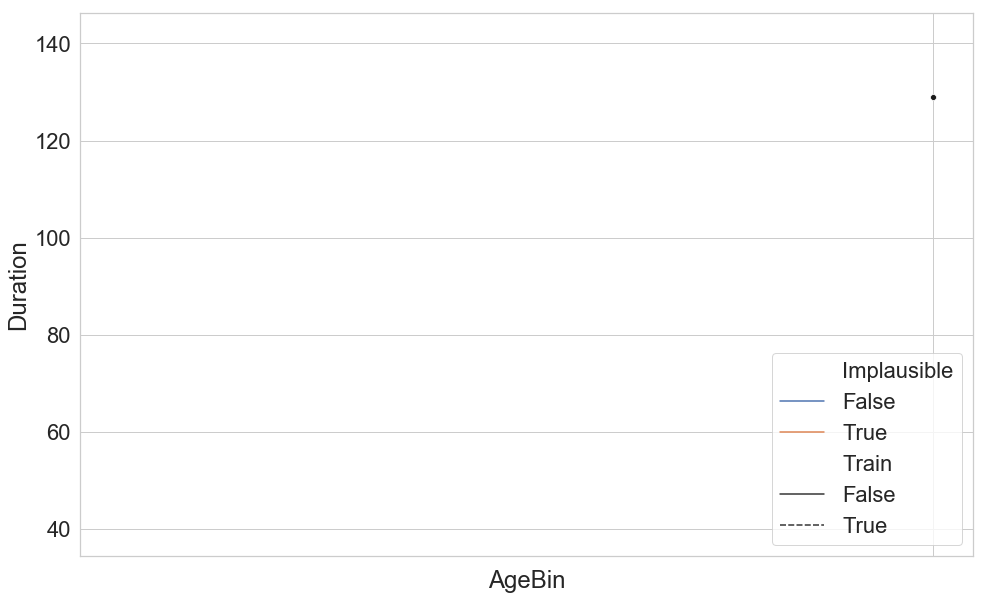

In [22]:
ar = all_results.reset_index()

data = ar.loc[ar['AgeBin']==age_bin[0]].groupby(['Sample_Id','AgeBin'])['Result'].mean().reset_index().set_index('Sample_Id')

train = hm.training_data
train['Train'] = True
test = hm.test_data
test['Train'] = False
train_test = pd.concat([train, test])

fig, ax = plt.subplots(figsize=(16,10))

# Reference
#ref_by_year = reference_data[['Prevalence']].reset_index()

ref_by_year = ref_df.loc[ref_df['Age bin'] == int(age_bin[0][:2])] \
    .groupby('Age bin') \
    .mean() \
    .reset_index()
print(ref_by_year)
print(data)
sns.lineplot(data=ref_by_year, x='Age bin', y='Mean', color='k', marker='o', alpha=1, lw=2, zorder=1);

# Sims
tmp = data.merge(train_test[['Sample_Orig', 'Implausible', 'Train']], left_on='Sample_Id', right_on='Sample_Orig')
print(tmp.head())
sns.lineplot(data=tmp, x='AgeBin', y='Result', hue='Implausible', style='Train', 
             units='Sample_Orig', estimator=None, alpha=0.5, lw=0.5,
             ax=ax, zorder=-1)
ax.set_xlabel('AgeBin');
ax.set_ylabel('Duration');
ax.set_xticks(ref_by_year['Age bin'].unique());